# Use Python <3.10

In [1]:
import sys
import numpy as np
from pathlib import Path
from vampires_calibration.csv_tools import write_fits_info_to_csv,read_csv,read_csv_physical_model_all_bins
from vampires_calibration.fitting import *
from vampires_calibration.utils import *
from vampires_calibration.plotting import plot_data_and_model
from pyMuellerMat.physical_models.charis_physical_models import *
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import pandas as pd
# Plot settings that I like
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "serif",
   # "font.serif": ["Palatino"],
    "font.size": 16,
   # "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathpazo}"
})
from vampires_calibration.constants import wavelength_bins


/home/thomasmc/miniconda3/envs/charisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1: Write FITS Info to CSV

This CSV writer will organize all relevant header information. Some header information is excluded from the extracted cubes but exists in the raw files. This function will match the info from raw headers by matching tags in the filenames. The CHARIS DPP rewrites these tags, so if you used the DPP at any point you will need to retitle all the frames to their original titles (there is a function in csv_tools.py to do this).

In [3]:
# Get paths to both processed and raw data 
# Make sure these directories have cubes with corresonding numbers
cube_dir = '/home/thomasmc/nbs_in/unpol/cubes'
raw_dir = '/home/thomasmc/nbs_in/unpol/raw'
csv_dir = '/home/thomasmc/nbs_in/unpol/csvs'

# Write all bins to csvs
for bin in range(0,22):
   csv_filepath = f'/home/thomasmc/nbs_in/unpol/csvs/bin{bin}.csv'
   write_fits_info_to_csv(cube_dir, raw_dir, csv_filepath,bin)



CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin0.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin1.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin2.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin3.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin4.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin5.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin6.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin7.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin8.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin9.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin10.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin11.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin12.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin13.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin14.csv
CSV file written to /home/thomasmc/nbs_in/unpol/csvs/bin15.csv
CS

# Step 2 (Optional): Plot Your Data With the Original Model 

The csv reader will read in `interleaved_values`: interleaved single differences and sums `[differences, sums...]`, `interleaved_stds`:poissan noise propagated standard deviations (which are not used anymore and is an artifact of old code), and a `configuration_list` of dictionaries where each dictionary represents the instrument configuration for a measurement. The rationale for assuming no noise is that it is so tiny when normalized over large numbers of pixels it is irrelevant. It also improves fit accuracy.

In [2]:
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# Weird things happen at the very lowest bins, so I recommend something more in the middle
filepath = Path('/home/thomasmc/nbs_in/unpol/csvs/bin15.csv')

# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  128
[-2.00892423e+06  6.32415913e+07 -5.64338349e+06  2.56616934e+08
 -5.82662970e+06  1.92714207e+08 -6.12836125e+06  2.66415239e+08
 -6.16130635e+06  2.27229770e+08]
Interleaved Stds
Length:  128
[ 7952.45819232  7952.45819232 16019.267595   16019.267595
 13882.15424928 13882.15424928 16322.23143653 16322.23143653
 15074.14244474 15074.14244474]
Configuration List
Length:  64
[{'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 11.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 56.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 33.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 78.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'thet

The Mueller matrix chain is contained in a pyMuellerMat system Mueller matrix object. These are generated using configuration dictionaries with the below format. You can generate a system dictionary with any function listed in the common_mm_functions.py script in the pyMuellerMat physical_models branch (can be found here: https://github.com/maxwellmb/pyMuellerMat/tree/physical_models/pyMuellerMat). Each component is within a `components` dictionary, listed from downstream to upstream. You can name each component, and give it a `type` which is the name of the commmon mm function. The `properties` are the case sensitive inputs to these functions. Tag each component as `internal`. With this system dict you can create your Mueller matrix with `generate_system_mueller_matrix()`.

In [3]:

# Loading in past fits 

offset_imr = 0.18563 # derotator offset
offset_hwp = -0.87823 # HWP offset
offset_cal = -0.44630 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0



# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "elliptical_retarder_function",
                "properties" : {"phi_h": 1, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"epsilon": 0, "delta_theta": 0},
                "tag": "internal",
            }},
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[ 0.5         0.49999035  0.00148931 -0.00272622]
 [ 0.5         0.49999035  0.00148931 -0.00272622]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


Here is where we can load in our old fit. The fit I have loaded in is my median posterior MCMC fit of the Joost 't Hart 2021 physical model. The physical model is contained in functions from the physical_models branch of pyMuellerMat. The fit is not very good, which prompted the switch to an elliptical polarizer model for the derotator. `p` and `system_parameters` are updates that will be placed into the Mueller matrix. This is because plotting function is made to use the same workflow as `minimize_system_mueller_matrix()` (If you would prefer to work without my wrapper function, follow the same procedure here to generate the model).

`p` is the float values of the parameters detailed in `system_parameters` which contains the float value's component name and what `property` it is in the `system_dict`. `modeled_interleaved` are the modeled single sums and differences generated from the `system_mm` and updated p values, which we then process into double sums and differences using `process_model()`. Note that, for CHARIS, the sums are irrelevant. `plot_data_and_model()` plots the double differences vs. HWP angle for all derotator angles. 

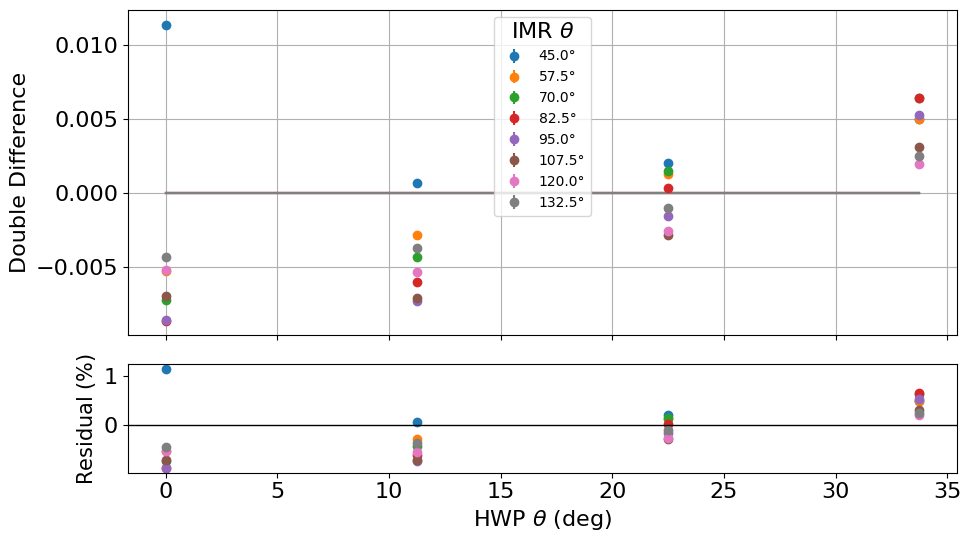

[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


np.float64(0.5763983328011287)

In [6]:

# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins,1.66725,1.30159)[15], IMR_retardance(wavelength_bins,259.14673)[15]]


# Define what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi_h']]

# Generate our modeled left and right beam intensities

modeled_interleaved = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(modeled_interleaved)

# Plot the modeled and observed values

fig, ax = plot_data_and_model(interleaved_values, diffs_sums,configuration_list, wavelength= wavelength_bins[15],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1932.png',bbox_inches='tight', dpi=600)
diffs = process_dataset(interleaved_values)[::2]
print(diffs_sums[::2])
pol_acc = np.sqrt(np.sum((diffs*100-diffs_sums[::2]*100)**2)/(len(diffs)-6))
pol_acc

# Step 3: Fit for Diattenuation

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1836e-02                                    2.17e-02    
       1              2         1.1812e-02      2.43e-05       2.18e-02       4.45e-05    
       2              3         1.1812e-02      7.44e-08       4.44e-02       9.52e-06    
       3              4         1.1811e-02      1.44e-07       8.84e-02       1.84e-05    
       4              5         1.1811e-02      2.69e-07       1.75e-01       3.44e-05    
       5              6         1.1811e-02      4.65e-07       3.44e-01       5.95e-05    
       6              7         1.1810e-02      6.62e-07       6.62e-01       8.45e-05    
       7              8         1.1810e-02      3.96e-07       8.40e-01       5.03e-05    
       8              9         1.1810e-02      2.17e-08       2.28e-01       2.73e-06    
       9             10         1.1810e-02      1.42e-10       1.98e-02       1.70e-08    

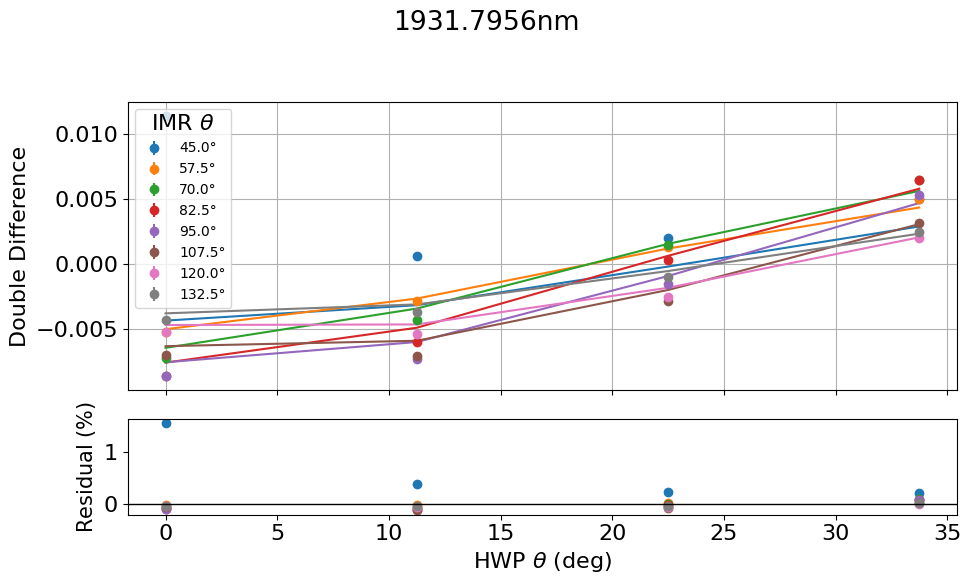

Updated Mueller Matrix:
[[ 0.49863845  0.15616493 -0.18638216 -0.43123106]
 [-0.49506145 -0.15734252  0.18772615  0.43432976]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.13346686167030508 1.569028821247545
s_res: 0.3439478718413283
Error: [6.32411252e-03 2.32343278e+01]


/tmp/ipykernel_2208059/4072235235.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


In [3]:
# Test fitting with the wavelength bin we plotted earlier
from vampires_calibration.instruments import fit_CHARIS_Mueller_matrix_by_bin_nbs_unpol
error, fig2, ax2,sres = fit_CHARIS_Mueller_matrix_by_bin_nbs_unpol(filepath, 15, 
    Path('/home/thomasmc/nbs_in/unpol/sys_dicts/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1932.png',bbox_inches='tight', dpi=600)



The elliptical IMR model is a huge improvement! Now we can fit for all bins. In this fit, I'm fitting for 3 elliptical retarder parameters and a Wollaston prism modulator term.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1056e-03                                    2.03e-02    
       1              2         1.0810e-03      2.45e-05       2.20e-02       5.19e-05    
       2              3         1.0810e-03      5.93e-08       4.48e-02       6.33e-06    
       3              4         1.0809e-03      1.08e-07       8.93e-02       8.64e-06    
       4              5         1.0807e-03      1.78e-07       1.77e-01       1.42e-05    
       5              6         1.0805e-03      2.06e-07       3.47e-01       1.66e-05    
       6              7         1.0805e-03      3.29e-08       1.96e-01       2.67e-06    
       7              8         1.0805e-03      6.81e-11       9.26e-03       5.25e-09    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 1.1056e-03, final cost 1.0805e-03, first-order optimality 5.25e-09.
     message: `gtol` termination 

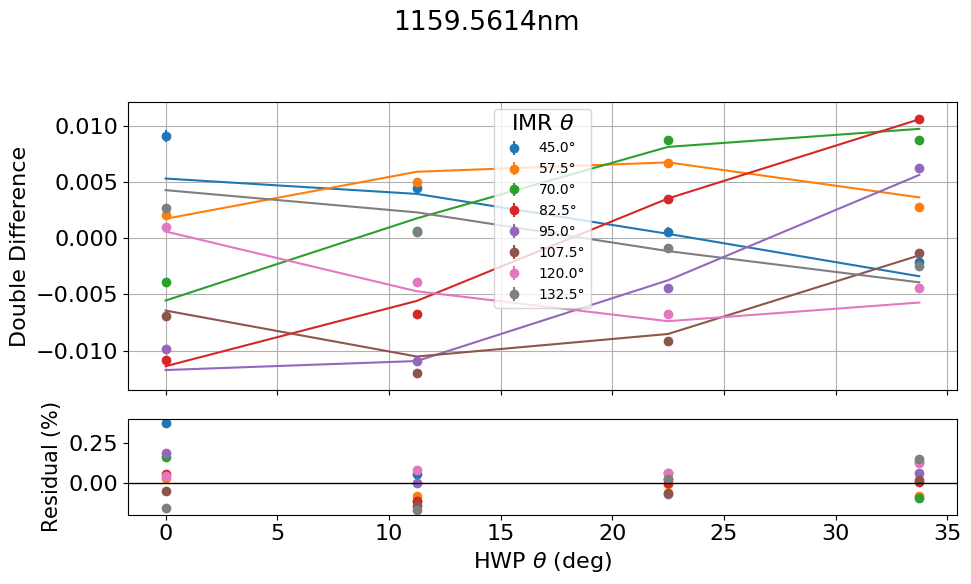

Updated Mueller Matrix:
[[ 0.50228943 -0.18858955  0.07370847  0.45966914]
 [-0.50228943  0.18858955 -0.07370847 -0.45966914]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.1752234905786803 0.37542953011854474
s_res: 0.13297533459200742
Error: [2.01905293e-03 4.71214554e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8503e-03                                    6.70e-03    
       1              2         2.8480e-03      2.28e-06       2.24e-02       1.86e-05    
       2              3         2.8478e-03      1.67e-07       4.48e-02       1.82e-05    
       3              4         2.8475e-03      3.23e-07       8.93e-02       3.00e-05    
       4              5         2.8469e-03      6.07e-07       1.77e-01       5.64e-05    
       5              6         2.8458e-03      1.06e-06       3.47e-01       9.89e-05    
    

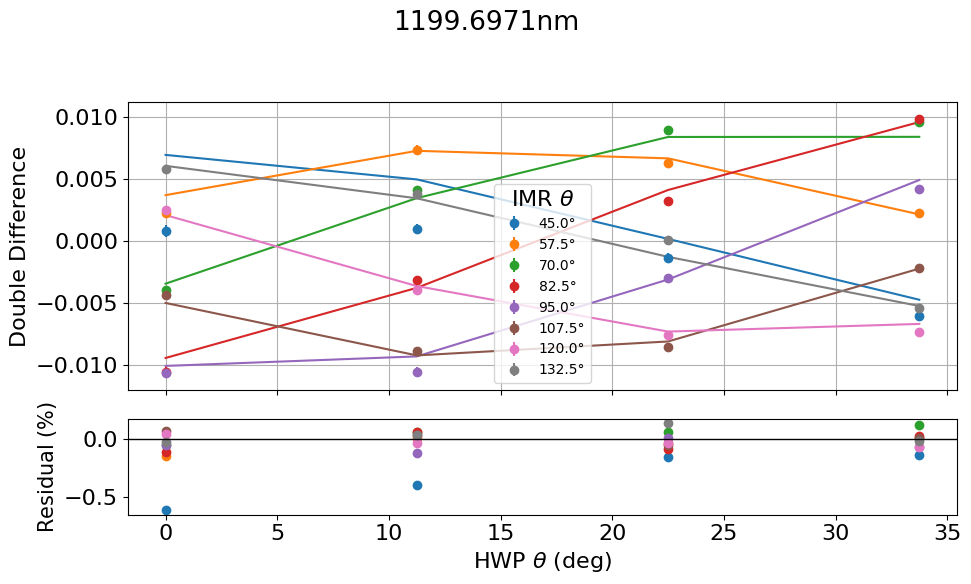

Updated Mueller Matrix:
[[ 0.50289429 -0.26193391  0.15966863  0.39359652]
 [-0.49902039  0.26390785 -0.16091496 -0.39668801]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6133693502935306 0.13732039443103172
s_res: 0.17182052703094253
Error: [2.97092521e-03 8.01091220e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3402e-03                                    1.23e-02    
       1              2         1.3339e-03      6.30e-06       2.24e-02       2.05e-05    
       2              3         1.3338e-03      1.58e-07       4.48e-02       1.72e-05    
       3              4         1.3335e-03      3.05e-07       8.93e-02       2.74e-05    
       4              5         1.3329e-03      5.61e-07       1.77e-01       5.05e-05    
       5              6         1.3320e-03      9.38e-07       3.47e-01       8.44e-05    
    

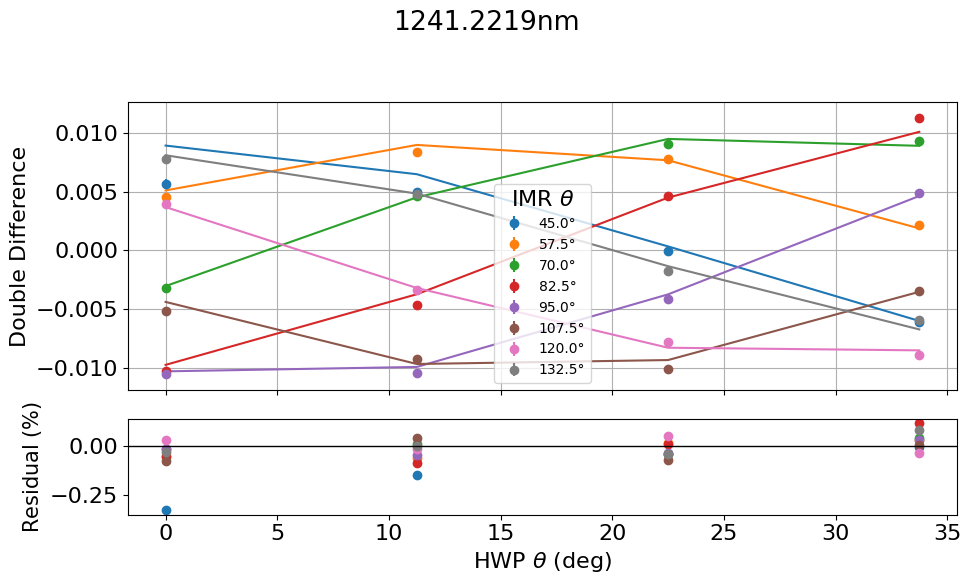

Updated Mueller Matrix:
[[ 0.50362282 -0.31936567  0.2185863   0.31963932]
 [-0.50193982  0.32041482 -0.21932736 -0.32072679]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.33003030879744155 0.11467367739444145
s_res: 0.09157469735425641
Error: [1.85899853e-03 4.86009177e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7121e-03                                    7.91e-03    
       1              2         1.7097e-03      2.31e-06       2.24e-02       1.56e-05    
       2              3         1.7096e-03      1.39e-07       4.48e-02       1.50e-05    
       3              4         1.7093e-03      2.65e-07       8.93e-02       2.48e-05    
       4              5         1.7089e-03      4.80e-07       1.77e-01       4.49e-05    
       5              6         1.7081e-03      7.67e-07       3.47e-01       7.19e-05    
   

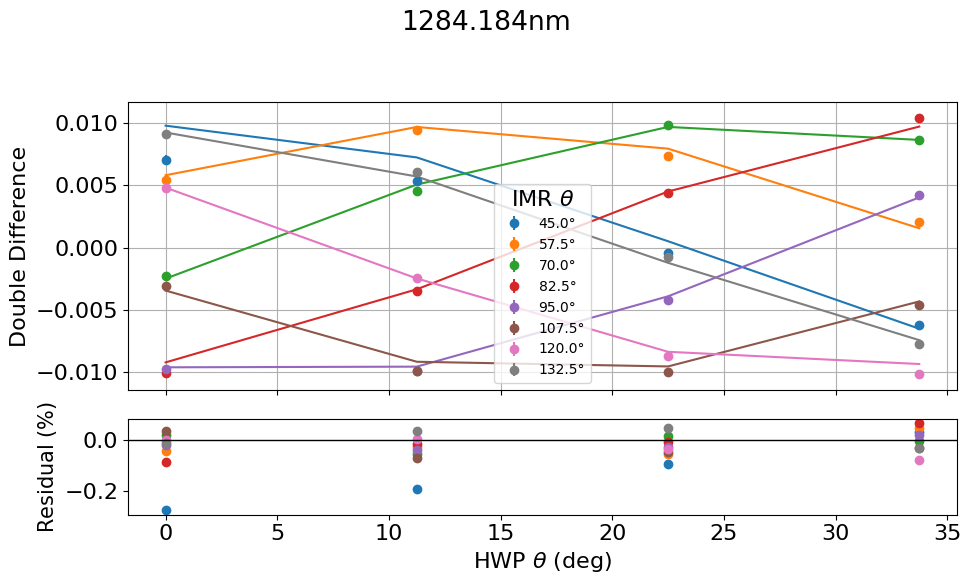

Updated Mueller Matrix:
[[ 0.50391197 -0.35952185  0.2766641   0.20472608]
 [-0.49770619  0.36394368 -0.2801615  -0.2073198 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.2772574539151932 0.06796488849435012
s_res: 0.08455435282088318
Error: [1.96842044e-03 5.35261757e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7924e-03                                    3.75e-03    
       1              2         3.7919e-03      5.30e-07       2.25e-02       1.29e-05    
       2              3         3.7918e-03      1.14e-07       4.48e-02       1.23e-05    
       3              4         3.7916e-03      2.15e-07       8.93e-02       2.08e-05    
       4              5         3.7912e-03      3.80e-07       1.77e-01       3.67e-05    
       5              6         3.7906e-03      5.69e-07       3.47e-01       5.50e-05    
    

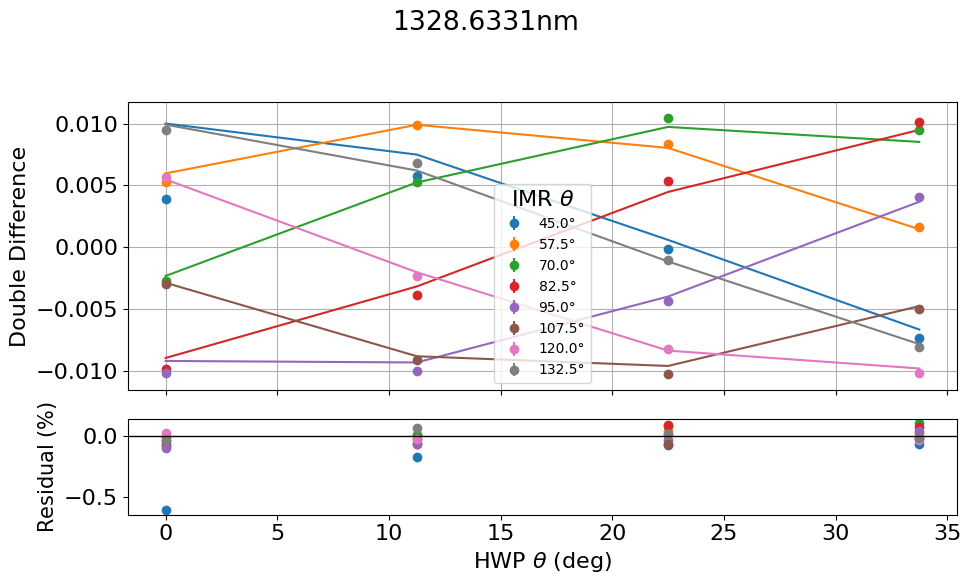

Updated Mueller Matrix:
[[ 0.50394778 -0.37526378  0.31959592  0.03143834]
 [-0.4939154   0.38280178 -0.32618423 -0.0320874 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6061226289232867 0.10026319377680581
s_res: 0.1427174729255364
Error: [2.83418164e-03 7.91606049e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9692e-03                                    2.82e-03    
       1              2         3.9689e-03      3.33e-07       2.25e-02       1.07e-05    
       2              3         3.9688e-03      9.47e-08       4.48e-02       1.02e-05    
       3              4         3.9686e-03      1.78e-07       8.93e-02       1.72e-05    
       4              5         3.9683e-03      3.09e-07       1.77e-01       3.00e-05    
       5              6         3.9679e-03      4.41e-07       3.47e-01       4.26e-05    
     

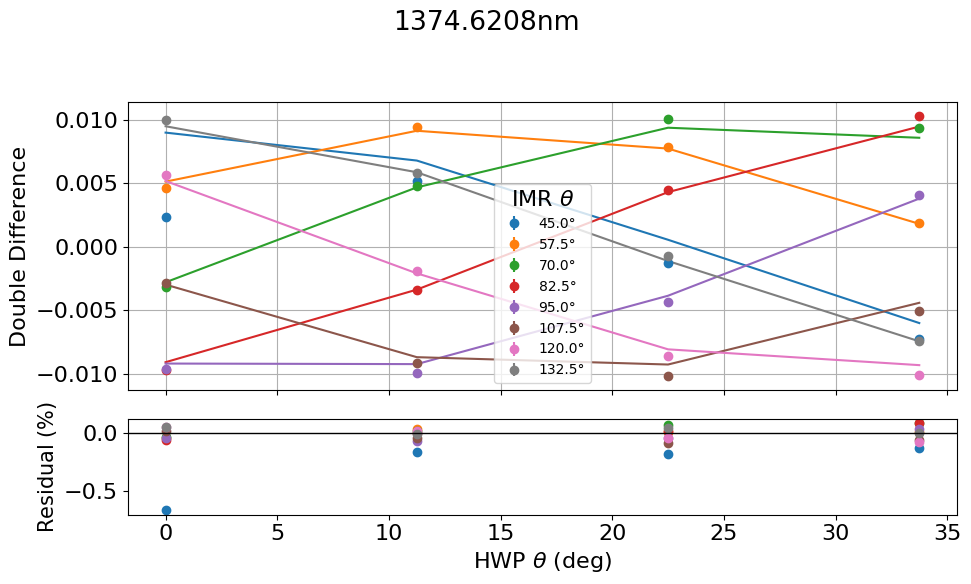

Updated Mueller Matrix:
[[ 0.50357103 -0.34194393  0.31872777 -0.17175667]
 [-0.49800914  0.34570383 -0.32233466  0.17370296]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6655054239917102 0.08097608708972515
s_res: 0.15619944711072228
Error: [2.99763276e-03 8.36993986e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7143e-03                                    3.86e-03    
       1              2         1.7137e-03      6.46e-07       2.25e-02       4.74e-06    
       2              3         1.7136e-03      4.10e-08       4.48e-02       4.33e-06    
       3              4         1.7135e-03      7.20e-08       8.93e-02       6.89e-06    
       4              5         1.7134e-03      1.05e-07       1.77e-01       9.97e-06    
       5              6         1.7134e-03      6.16e-08       2.61e-01       5.80e-06    
    

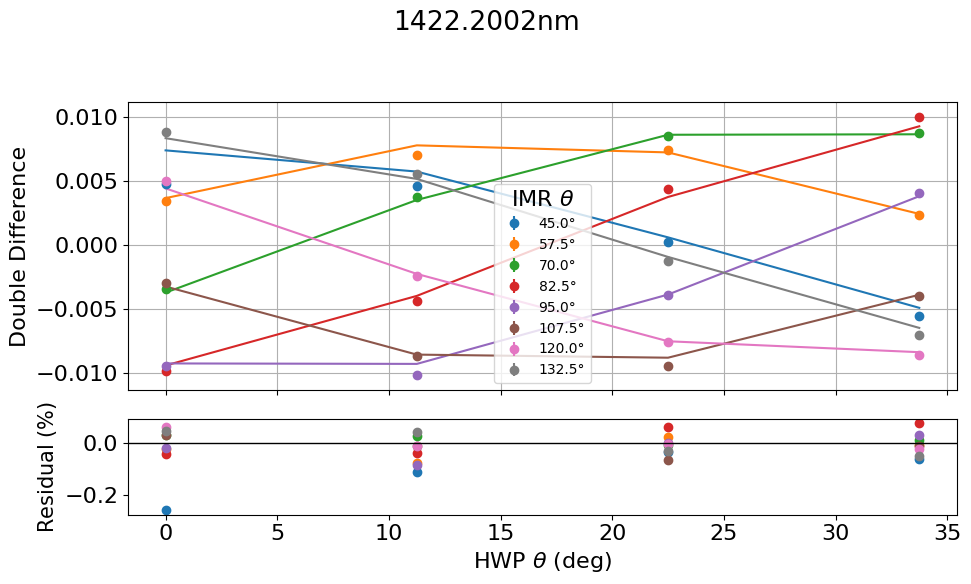

Updated Mueller Matrix:
[[ 0.50295014 -0.2850442   0.28520709 -0.29229089]
 [-0.49802299  0.28779546 -0.28806058  0.2952175 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.2593785388449194 0.07436741305286432
s_res: 0.07451688896599554
Error: [2.12685964e-03 5.84365937e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4994e-03                                    7.87e-04    
       1              2         1.4993e-03      5.49e-08       2.25e-02       5.09e-06    
       2              3         1.4993e-03      4.46e-08       4.48e-02       4.76e-06    
       3              4         1.4992e-03      8.11e-08       8.93e-02       7.95e-06    
       4              5         1.4990e-03      1.31e-07       1.77e-01       1.28e-05    
       5              6         1.4989e-03      1.41e-07       3.47e-01       1.36e-05    
    

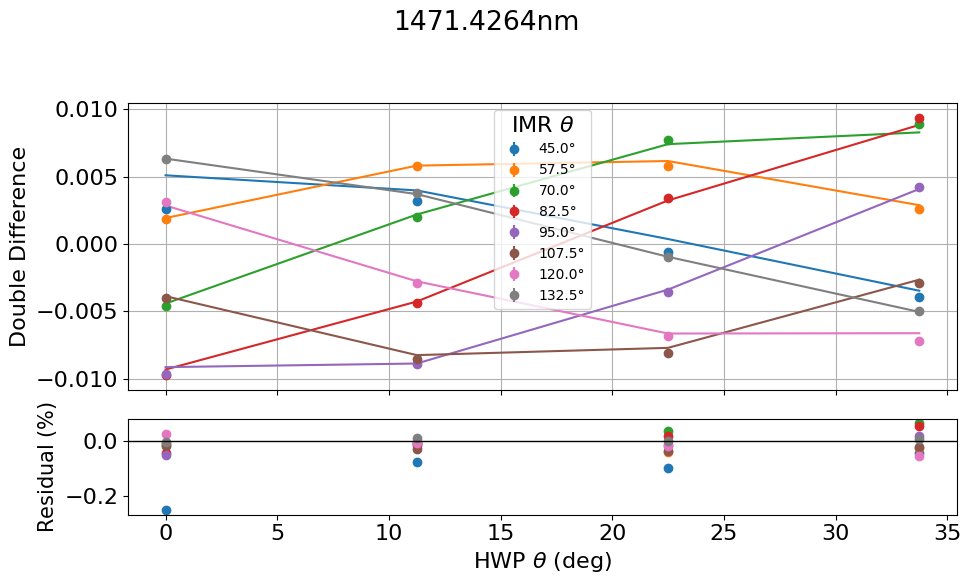

Updated Mueller Matrix:
[[ 0.50213098 -0.2099935   0.22842725 -0.38964944]
 [-0.49809902  0.21162614 -0.23028997  0.39283088]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.25153699016639874 0.06204387132944955
s_res: 0.06594918547081093
Error: [2.20085516e-03 6.16274072e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.6896e-04                                    8.39e-04    
       1              2         8.6891e-04      5.38e-08       2.25e-02       2.23e-06    
       2              3         8.6889e-04      1.90e-08       4.48e-02       1.97e-06    
       3              4         8.6886e-04      3.14e-08       8.93e-02       3.06e-06    
       4              5         8.6882e-04      3.71e-08       1.77e-01       3.58e-06    
       5              6         8.6881e-04      6.23e-09       1.05e-01       5.90e-07    
   

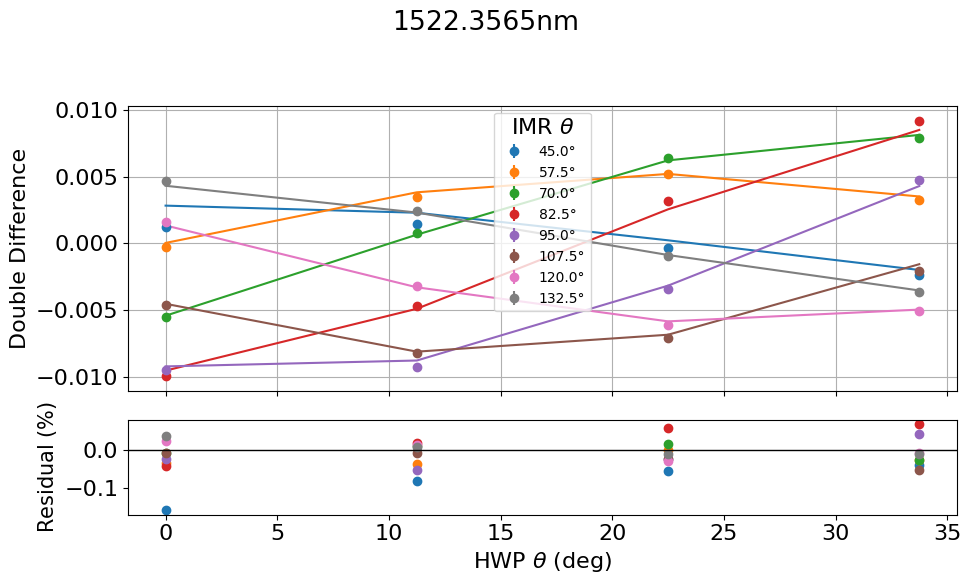

Updated Mueller Matrix:
[[ 0.50129245 -0.13056555  0.15979467 -0.4520595 ]
 [-0.49692965  0.13162913 -0.16120359  0.4560492 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.1595248449213933 0.07002157136207132
s_res: 0.051452671200142325
Error: [1.84209344e-03 5.12621124e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2868e-04                                    5.58e-04    
       1              2         1.2865e-04      2.90e-08       2.25e-02       1.64e-06    
       2              3         1.2864e-04      1.38e-08       4.48e-02       1.41e-06    
       3              4         1.2862e-04      2.17e-08       8.93e-02       2.12e-06    
       4              5         1.2860e-04      2.05e-08       1.77e-01       1.96e-06    
       5              6         1.2860e-04      5.13e-10       3.25e-02       4.86e-08    
   

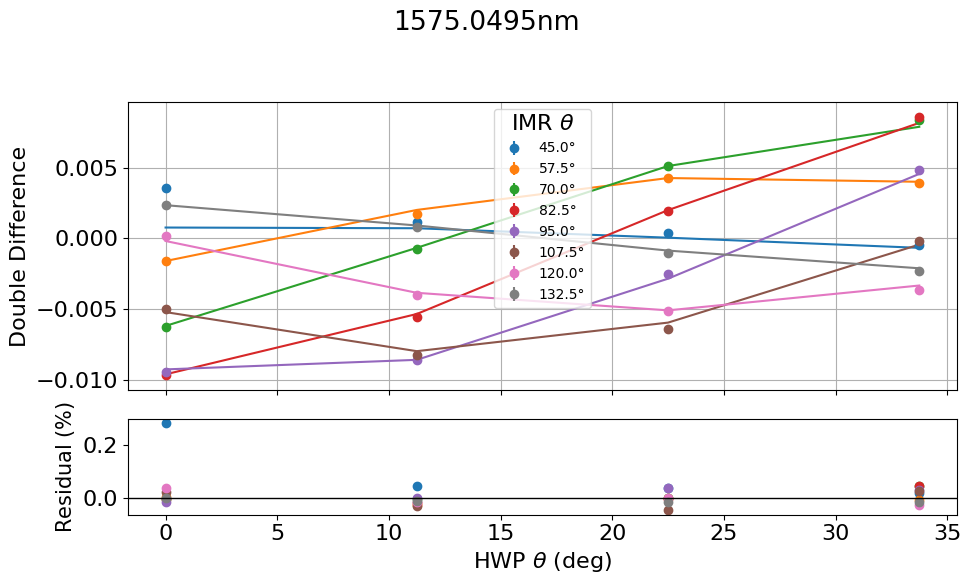

Updated Mueller Matrix:
[[ 0.50055792 -0.05924796  0.09205143 -0.48529681]
 [-0.49749018  0.05955207 -0.09261954  0.48829611]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.04800178757425333 0.2825922485828887
s_res: 0.06410675125510241
Error: [7.47091395e-04 2.08305432e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7781e-03                                    4.81e-04    
       1              2         1.7781e-03      1.97e-08       2.22e-02       8.41e-07    
       2              3         1.7781e-03      6.62e-09       4.44e-02       6.57e-07    
       3              4         1.7780e-03      7.90e-09       8.84e-02       7.74e-07    
       4              5         1.7780e-03      1.36e-09       5.43e-02       1.31e-07    
       5              6         1.7780e-03      2.26e-13       9.63e-04       2.98e-09    
`gto

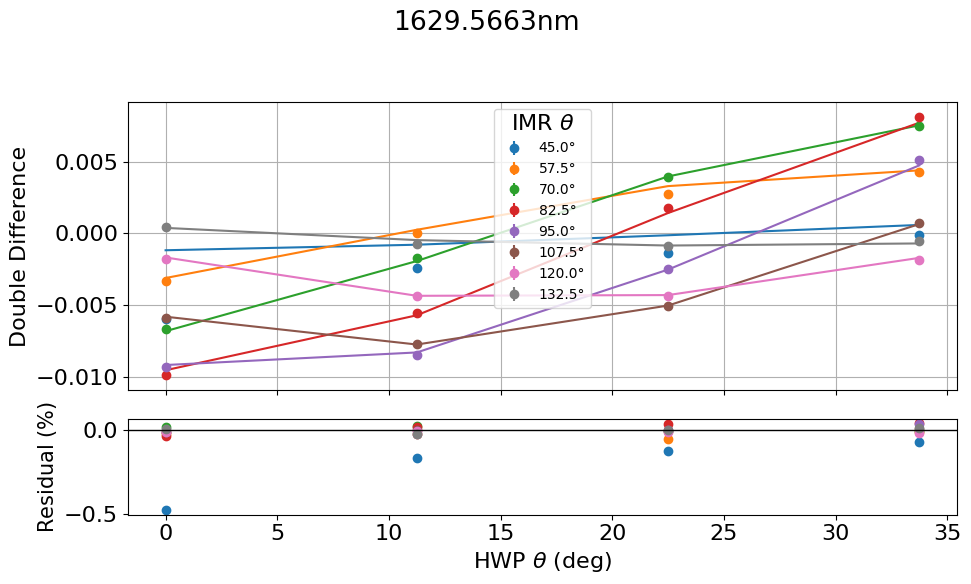

Updated Mueller Matrix:
[[ 0.49986118  0.00916397  0.02102374 -0.49556159]
 [-0.49609162 -0.00930871 -0.02118285  0.49932501]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.4788011223268318 0.04256483114461018
s_res: 0.10994855062932071
Error: [2.81736934e-03 7.98506963e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3837e-03                                    3.14e-04    
       1              2         2.3837e-03      7.45e-09       2.22e-02       1.86e-07    
       2              3         2.3837e-03      7.47e-10       3.95e-02       7.34e-08    
       3              4         2.3837e-03      6.15e-14       2.72e-04       7.73e-10    
`gtol` termination condition is satisfied.
Function evaluations 4, initial cost 2.3837e-03, final cost 2.3837e-03, first-order optimality 7.73e-10.
     message: `gtol` termination condi

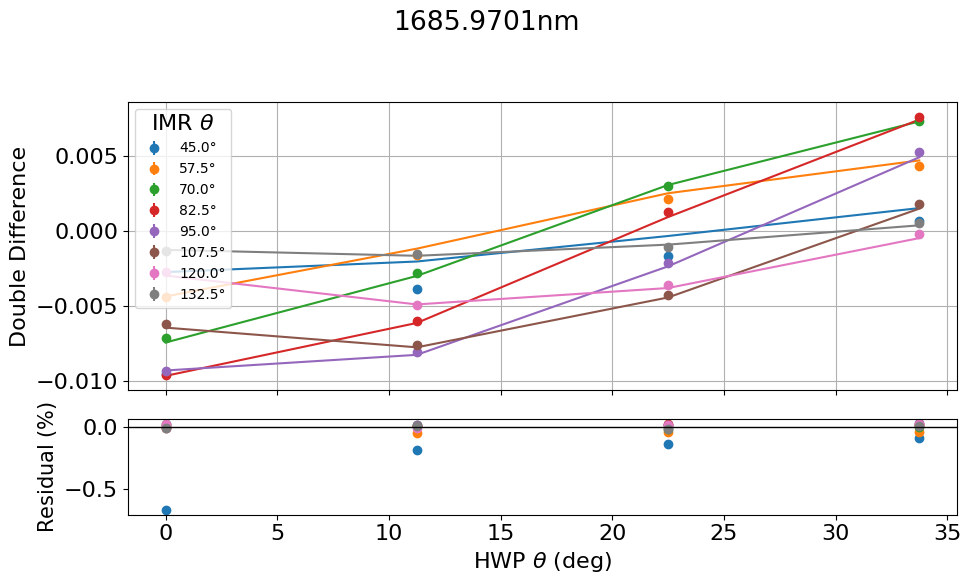

Updated Mueller Matrix:
[[ 0.49932694  0.06252022 -0.03993395 -0.4903914 ]
 [-0.49597067 -0.06300913  0.04020359  0.49370091]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6779565992612671 0.0356484666196919
s_res: 0.14893064452241622
Error: [3.18715147e-03 9.04288980e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4200e-04                                    4.27e-03    
       1              2         1.4088e-04      1.13e-06       2.22e-02       3.82e-06    
       2              3         1.4084e-04      3.32e-08       4.44e-02       3.59e-06    
       3              4         1.4078e-04      6.07e-08       8.84e-02       6.34e-06    
       4              5         1.4068e-04      9.95e-08       1.75e-01       1.04e-05    
       5              6         1.4057e-04      1.15e-07       3.44e-01       1.19e-05    
     

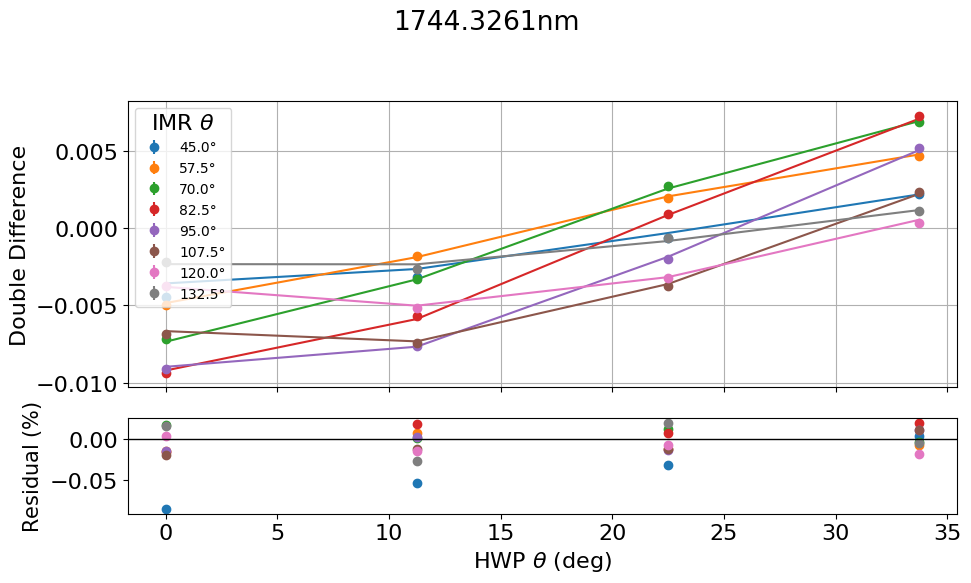

Updated Mueller Matrix:
[[ 0.49900171  0.09802889 -0.08567215 -0.47906152]
 [-0.4964364  -0.09858205  0.08611456  0.4815271 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.0867841216171743 0.020441973016808834
s_res: 0.026559444302036543
Error: [7.48874635e-04 2.24095367e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2677e-04                                    7.42e-03    
       1              2         2.2362e-04      3.15e-06       2.22e-02       4.90e-06    
       2              3         2.2359e-04      2.50e-08       4.44e-02       2.71e-06    
       3              4         2.2355e-04      4.45e-08       8.84e-02       4.81e-06    
       4              5         2.2348e-04      6.76e-08       1.75e-01       7.30e-06    
       5              6         2.2343e-04      5.28e-08       3.21e-01       5.64e-06    
  

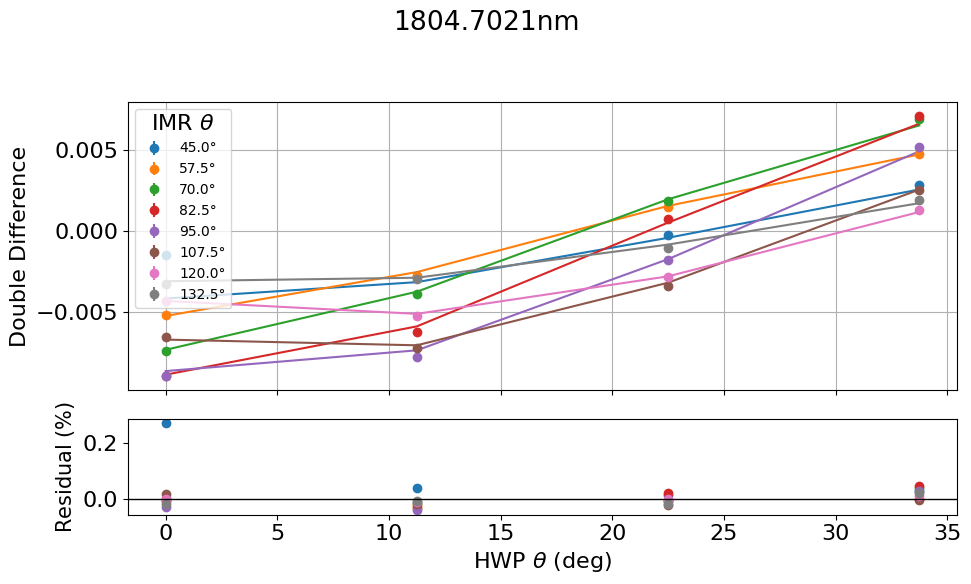

Updated Mueller Matrix:
[[ 0.4987965   0.12403666 -0.12667958 -0.46290967]
 [-0.49569944 -0.12486455  0.12746856  0.46578785]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.04073307992166242 0.2690642052008577
s_res: 0.06014707034062992
Error: [9.14568673e-04 2.84229879e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2971e-03                                    1.62e-02    
       1              2         6.2830e-03      1.41e-05       2.20e-02       2.46e-05    
       2              3         6.2829e-03      6.65e-08       4.44e-02       7.99e-06    
       3              4         6.2828e-03      1.28e-07       8.84e-02       1.54e-05    
       4              5         6.2826e-03      2.36e-07       1.75e-01       2.83e-05    
       5              6         6.2822e-03      3.94e-07       3.44e-01       4.73e-05    
    

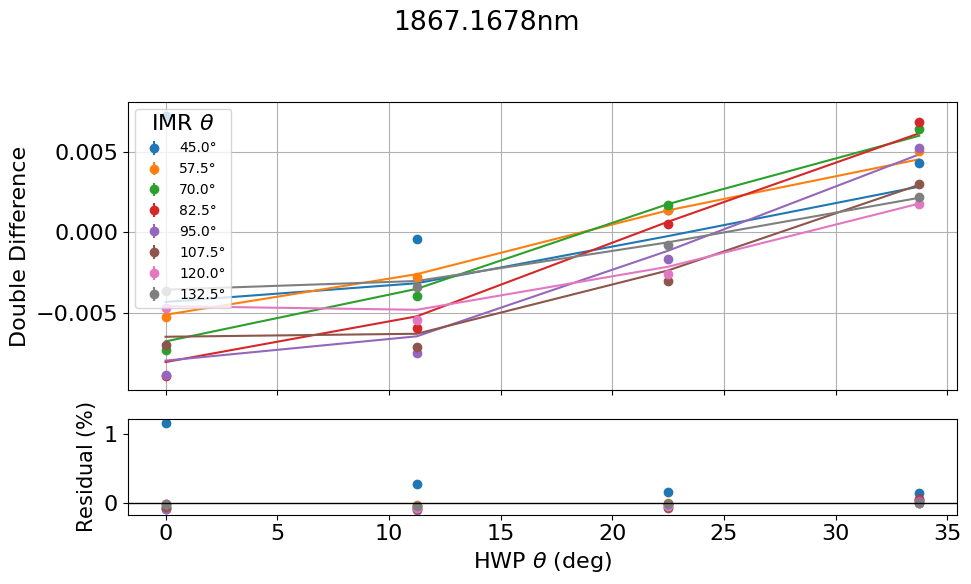

Updated Mueller Matrix:
[[ 0.49867098  0.14579111 -0.16124201 -0.44538811]
 [-0.4956051  -0.14673876  0.16223766  0.4481286 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.10176480403351928 1.1539749565901571
s_res: 0.2521494314118144
Error: [4.70048206e-03 1.62059501e+01]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1836e-02                                    2.17e-02    
       1              2         1.1812e-02      2.43e-05       2.18e-02       4.45e-05    
       2              3         1.1812e-02      7.44e-08       4.44e-02       9.52e-06    
       3              4         1.1811e-02      1.44e-07       8.84e-02       1.84e-05    
       4              5         1.1811e-02      2.69e-07       1.75e-01       3.44e-05    
       5              6         1.1811e-02      4.65e-07       3.44e-01       5.95e-05    
     

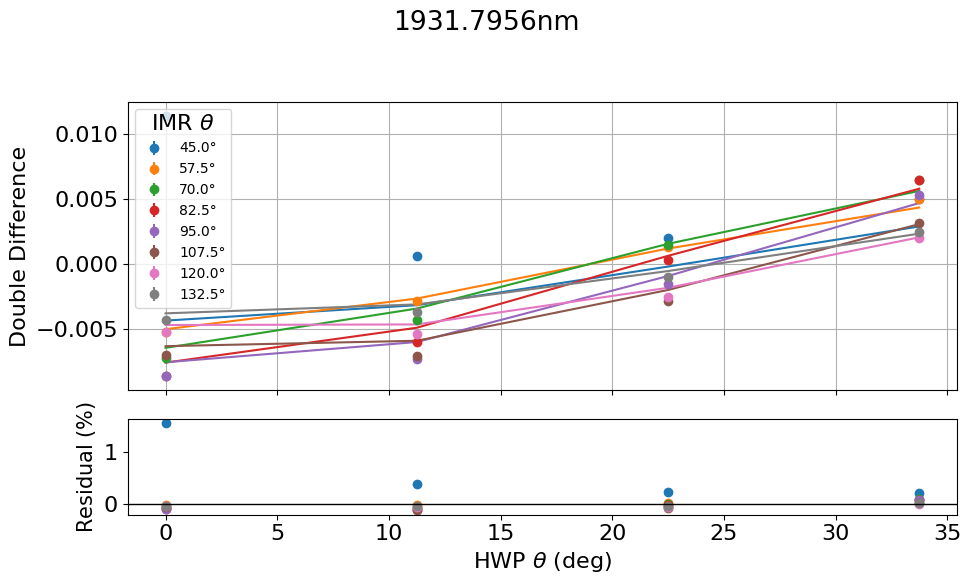

Updated Mueller Matrix:
[[ 0.49863845  0.15616493 -0.18638216 -0.43123106]
 [-0.49506145 -0.15734252  0.18772615  0.43432976]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.13346686167030508 1.569028821247545
s_res: 0.3439478718413283
Error: [6.32411252e-03 2.32343278e+01]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4755e-02                                    2.48e-02    
       1              2         1.4724e-02      3.10e-05       2.17e-02       5.80e-05    
       2              3         1.4724e-02      7.47e-08       4.44e-02       9.89e-06    
       3              4         1.4724e-02      1.45e-07       8.84e-02       1.92e-05    
       4              5         1.4723e-02      2.71e-07       1.75e-01       3.59e-05    
       5              6         1.4723e-02      4.73e-07       3.44e-01       6.26e-05    
      

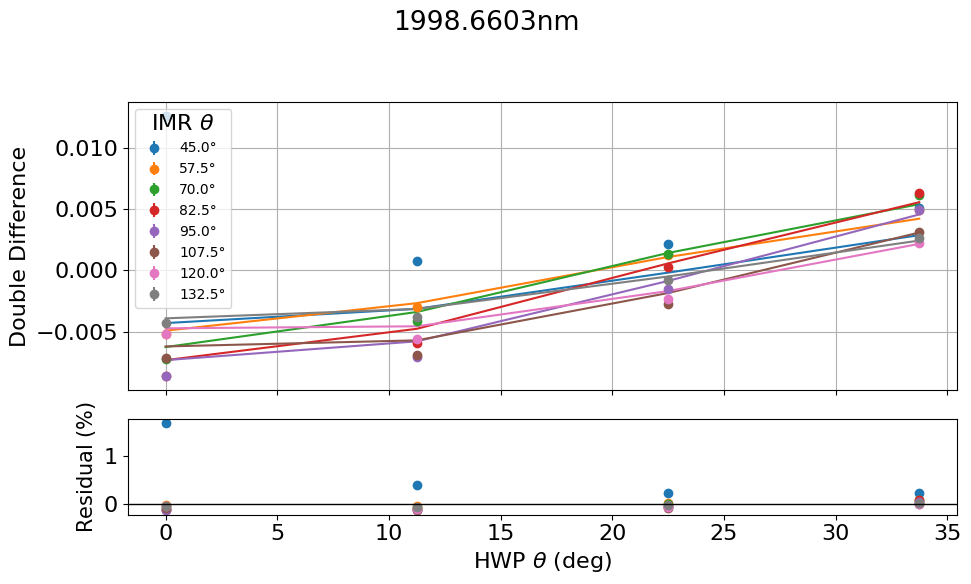

Updated Mueller Matrix:
[[ 0.49864346  0.15941501 -0.20445264 -0.42301303]
 [-0.49613902 -0.16025277  0.2054824   0.4251367 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.13117208483696619 1.688566410911585
s_res: 0.368863717087554
Error: [6.97443904e-03 2.65480271e+01]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3895e-02                                    2.63e-02    
       1              2         1.3860e-02      3.46e-05       2.16e-02       6.55e-05    
       2              3         1.3860e-02      6.81e-08       4.44e-02       9.17e-06    
       3              4         1.3860e-02      1.31e-07       8.84e-02       1.78e-05    
       4              5         1.3860e-02      2.46e-07       1.75e-01       3.32e-05    
       5              6         1.3859e-02      4.24e-07       3.44e-01       5.73e-05    
       

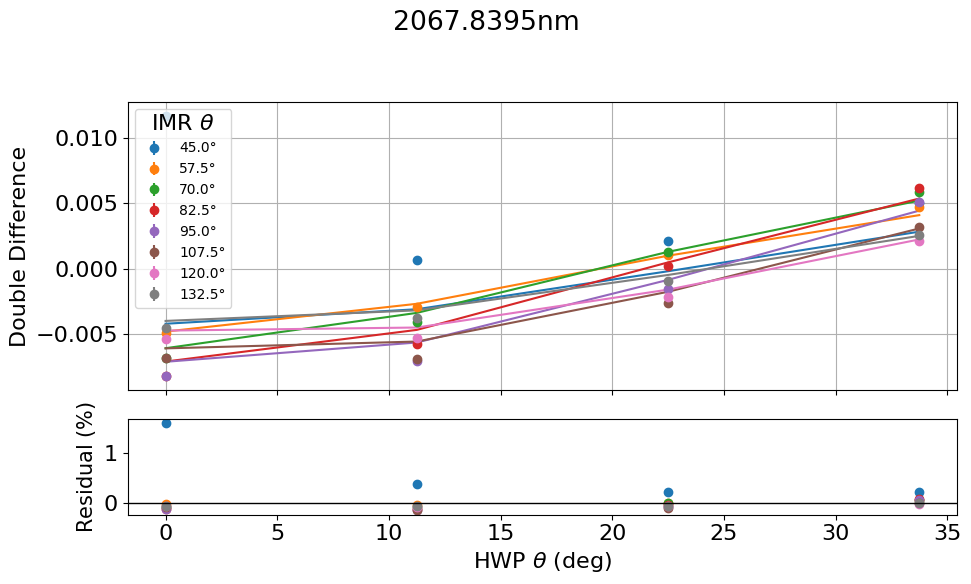

Updated Mueller Matrix:
[[ 0.49866691  0.1592656  -0.22046812 -0.41212415]
 [-0.49377911 -0.1609056   0.22264474  0.41618165]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.14018279745598072 1.5954278944521303
s_res: 0.34980492510570677
Error: [6.74538325e-03 2.61753650e+01]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5993e-02                                    2.85e-02    
       1              2         1.5953e-02      4.03e-05       2.15e-02       7.73e-05    
       2              3         1.5953e-02      6.13e-08       4.44e-02       8.48e-06    
       3              4         1.5952e-02      1.18e-07       8.84e-02       1.64e-05    
       4              5         1.5952e-02      2.19e-07       1.75e-01       3.05e-05    
       5              6         1.5952e-02      3.76e-07       3.44e-01       5.23e-05    
    

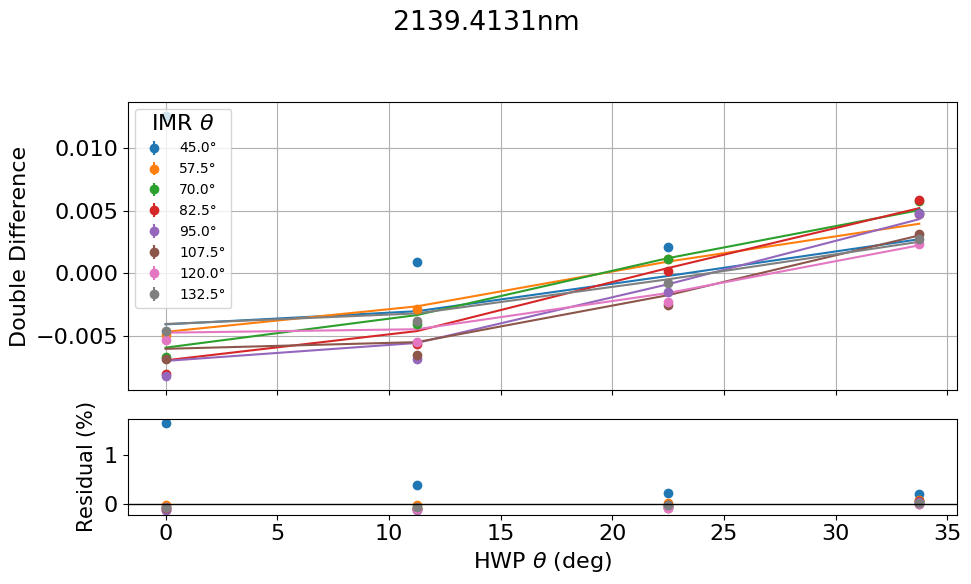

Updated Mueller Matrix:
[[ 0.49872793  0.15595581 -0.23335502 -0.40633954]
 [-0.49385057 -0.15755794  0.23565338  0.41033195]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.12717450013757514 1.658258021110758
s_res: 0.36153370259222783
Error: [7.22429216e-03 2.88869767e+01]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7705e-02                                    2.83e-02    
       1              2         1.7664e-02      4.07e-05       2.15e-02       7.85e-05    
       2              3         1.7664e-02      5.03e-08       4.44e-02       6.98e-06    
       3              4         1.7664e-02      9.60e-08       8.84e-02       1.34e-05    
       4              5         1.7664e-02      1.77e-07       1.75e-01       2.47e-05    
       5              6         1.7663e-02      2.94e-07       3.44e-01       4.10e-05    
     

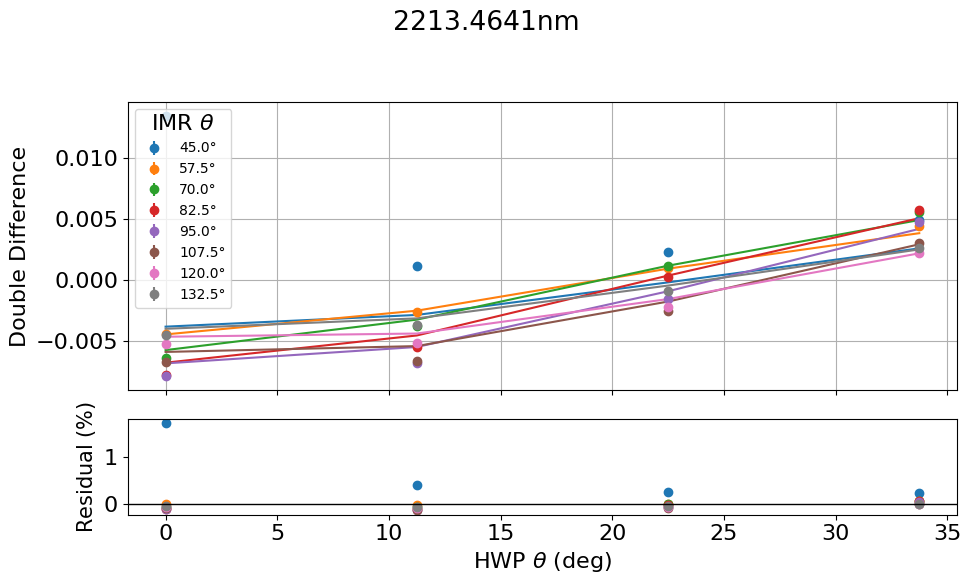

Updated Mueller Matrix:
[[ 0.49880479  0.14837241 -0.24165687 -0.40095481]
 [-0.49109757 -0.15079964  0.24543833  0.40721662]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.13325035343616043 1.7339122396886202
s_res: 0.37722050308793525
Error: [7.67234690e-03 3.09089031e+01]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7010e-02                                    2.73e-02    
       1              2         1.6972e-02      3.84e-05       2.15e-02       7.46e-05    
       2              3         1.6972e-02      3.73e-08       4.44e-02       5.13e-06    
       3              4         1.6972e-02      7.03e-08       8.84e-02       9.74e-06    
       4              5         1.6972e-02      1.26e-07       1.75e-01       1.74e-05    
       5              6         1.6972e-02      1.94e-07       3.44e-01       2.69e-05    
    

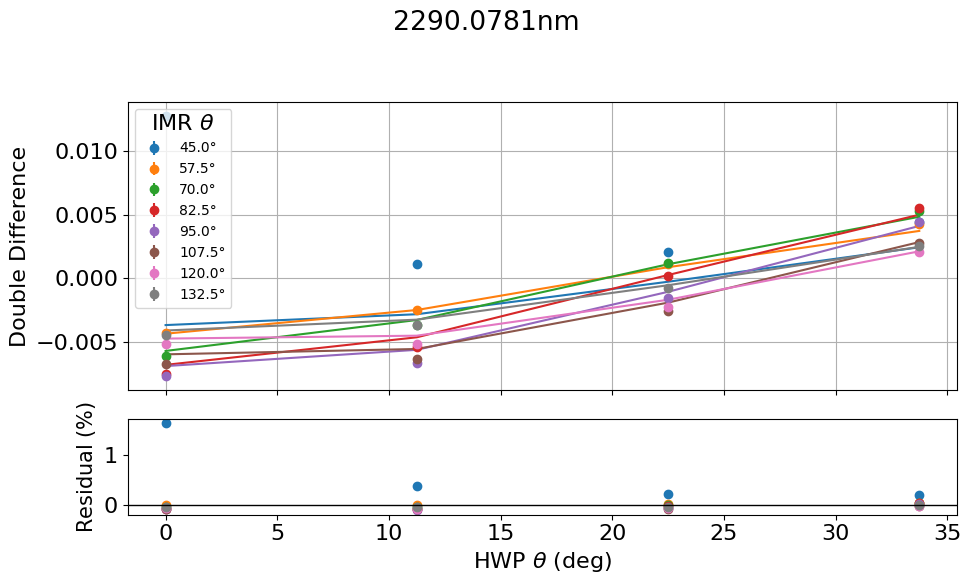

Updated Mueller Matrix:
[[ 0.49889457  0.13794195 -0.25294732 -0.39556601]
 [-0.48936935 -0.14075214  0.25785537  0.40323045]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.10019250741902685 1.643976913144827
s_res: 0.35494188083490985
Error: [7.58160181e-03 3.03694668e+01]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9153e-02                                    2.72e-02    
       1              2         1.9112e-02      4.01e-05       2.15e-02       7.82e-05    
       2              3         1.9112e-02      3.49e-08       4.44e-02       4.89e-06    
       3              4         1.9112e-02      6.57e-08       8.84e-02       9.29e-06    
       4              5         1.9112e-02      1.18e-07       1.75e-01       1.67e-05    
       5              6         1.9112e-02      1.83e-07       3.44e-01       2.59e-05    
     

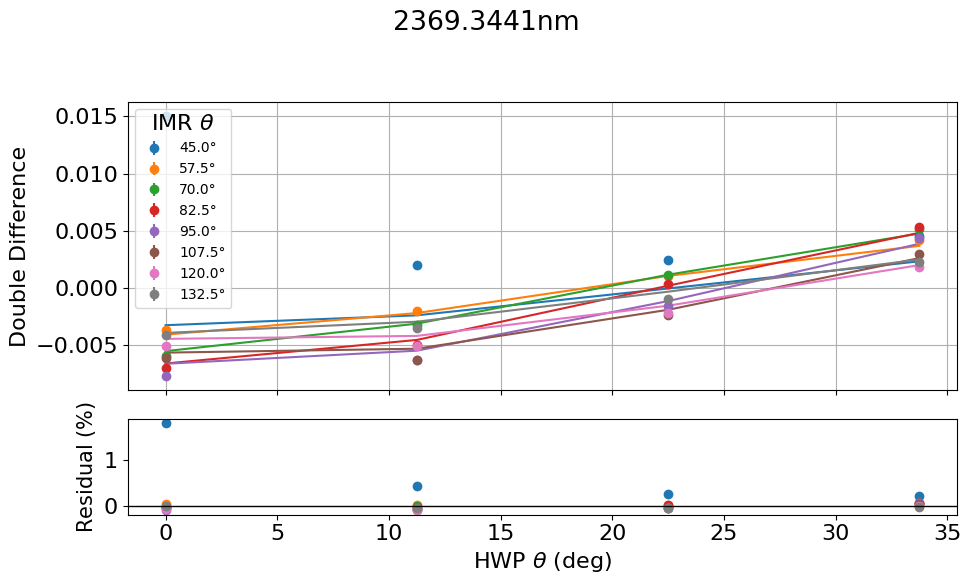

Updated Mueller Matrix:
[[ 0.49897722  0.12916256 -0.24868708 -0.39245925]
 [-0.4822362  -0.13386599  0.25729564  0.40602509]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.10609524199314435 1.8257034254361226
s_res: 0.3933542741335165
Error: [8.25465999e-03 3.37454837e+01]


In [4]:
# Fit all 22 wavelength bins
from vampires_calibration.instruments import fit_CHARIS_Mueller_matrix_by_bin
from pathlib import Path
errors = []
sres_list = []
for bin in range(0,22):
    error,fig,ax,sres = fit_CHARIS_Mueller_matrix_by_bin_nbs_unpol(
        f'../datacsvs/nbs_in_internalcal_unpol/bin{bin}.csv',bin,
        Path(f'../system_dictionaries/nbs_in_unpol_internalcal/bin{bin}.json'),
    )
    errors.append(error)
    sres_list.append(sres)



In [5]:
# find average error
import numpy as np
errors = np.array(errors)
print('phi_h', np.mean(errors[:,0]))
print('phi_45',np.mean(errors[:,1]))
print('phi_r',np.mean(errors[:,2]))
print('wol_eta',np.mean(errors[:,3]))




    

phi_h 0.007910203324522263
phi_45 0.08804257945234543


IndexError: index 2 is out of bounds for axis 1 with size 2

Text(0.5, 1.0, 'Polarimetric Accuracy')

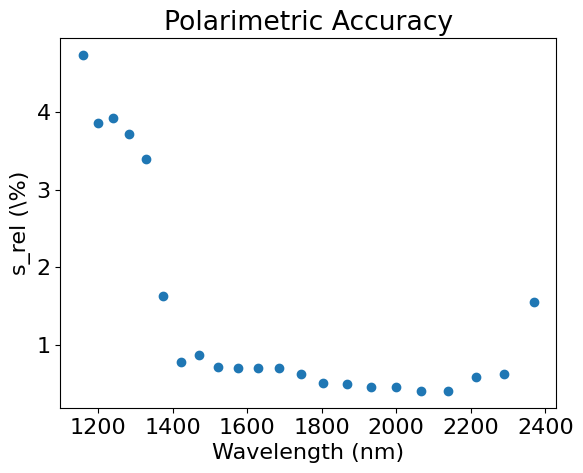

In [6]:
# plot pol accuracy
import matplotlib.pyplot as plt
plt.scatter(wavelength_bins,sres_list)
plt.xlabel('Wavelength (nm)')
plt.ylabel('s_rel (\%)')
plt.title('Polarimetric Accuracy')

`model_data` will list out all of your fits in a data frame.

In [7]:
from vampires_calibration.csv_tools import model_data
json_dir = '../system_dictionaries/nbs_in'
df = model_data(json_dir, offsets=False)
df

,wavelength_bin,nbs_ret_delta_theta,nbs_ret_phi
0,1159.5614,0.506221,3.123199
1,1199.6971,0.773738,3.133447
2,1241.2219,0.653881,3.136432
3,1284.1840,0.616034,3.149316
4,1328.6331,0.537226,3.293262
5,1374.6208,0.359840,3.159809
6,1422.2002,0.290663,3.146935
7,1471.4264,0.246340,3.145601
8,1522.3565,0.200253,3.147327
9,1575.0495,0.161887,3.145732


There's a few different ways to plot this fit. Feel free to check out all plotting methods in `plotting.py`. I'm going to plot the fitted elliptical retardance parameters vs. wavelength against the Joost 't Hart 2021 model using the folder of JSON dictionaries.

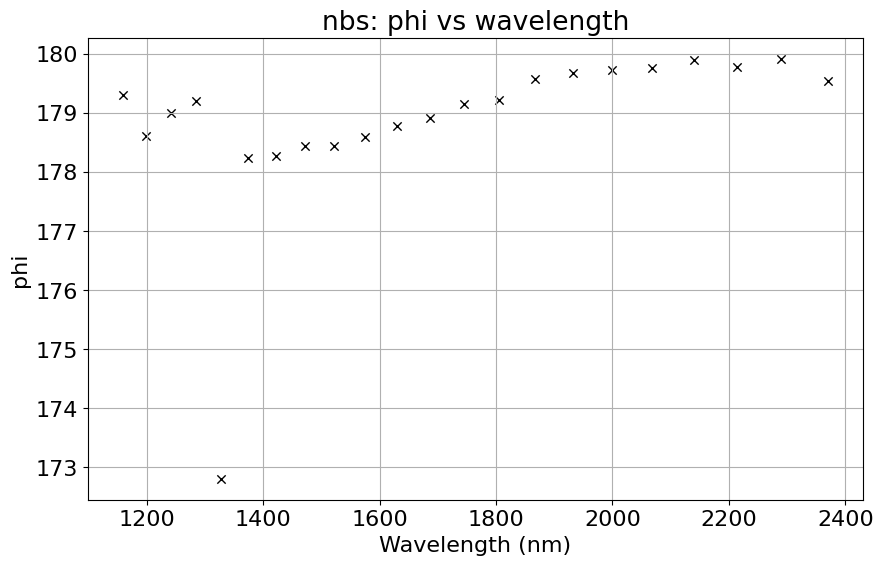

In [19]:
from vampires_calibration.plotting import plot_config_dict_vs_wavelength
params, fig, ax = plot_config_dict_vs_wavelength('nbs', 'phi', json_dir)
#fig, ax = plt.subplots(figsize=(10,6))
#ax.scatter(wavelength_bins, np.rad2deg(params))
#ax.plot(wavelength_bins,np.rad2deg((IMR_retardance(wavelength_bins,264.14673))), label='IMR Retardance Model', color='black', linestyle='--')

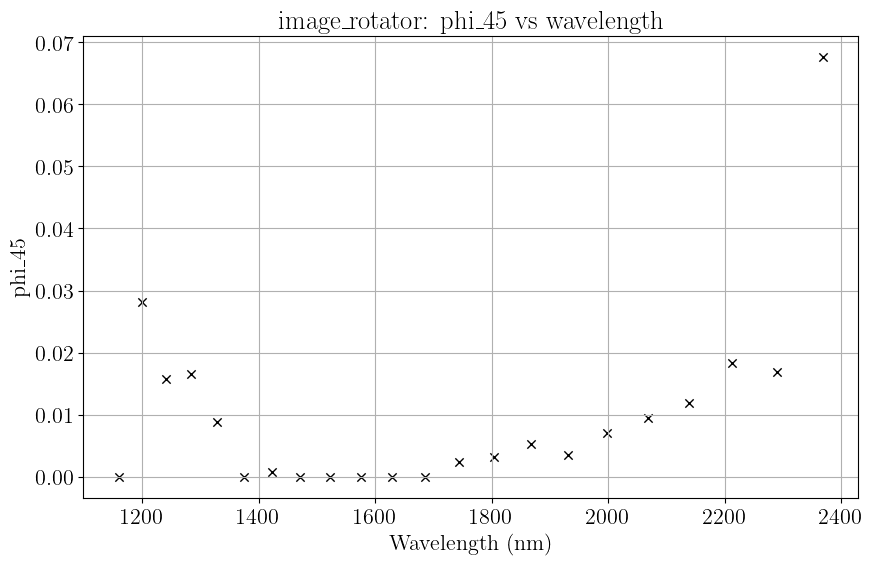

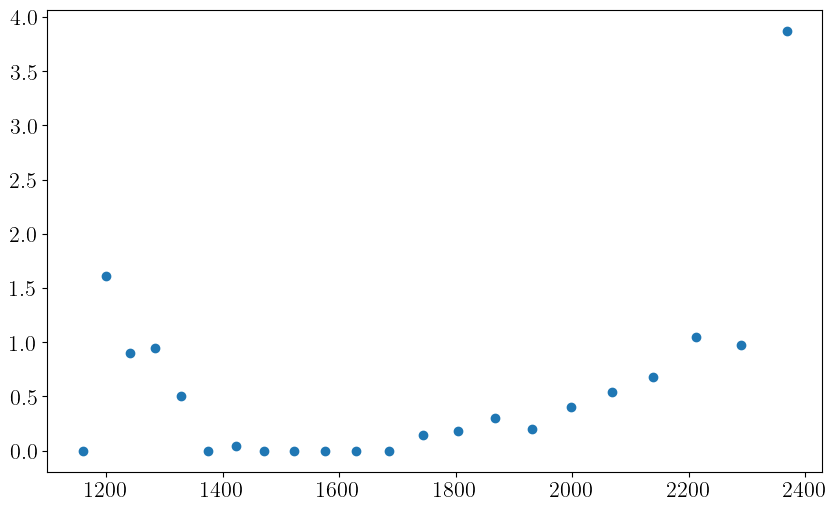

In [ ]:
# plot 45 degree linear retardance
params, fig, ax = plot_config_dict_vs_wavelength('image_rotator', 'phi_45', json_dir)
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(wavelength_bins, np.rad2deg(params))

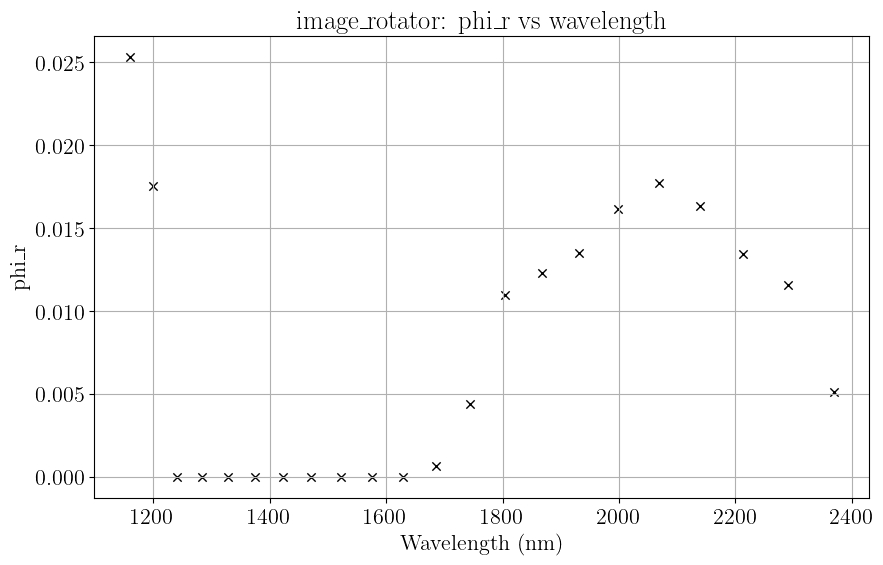

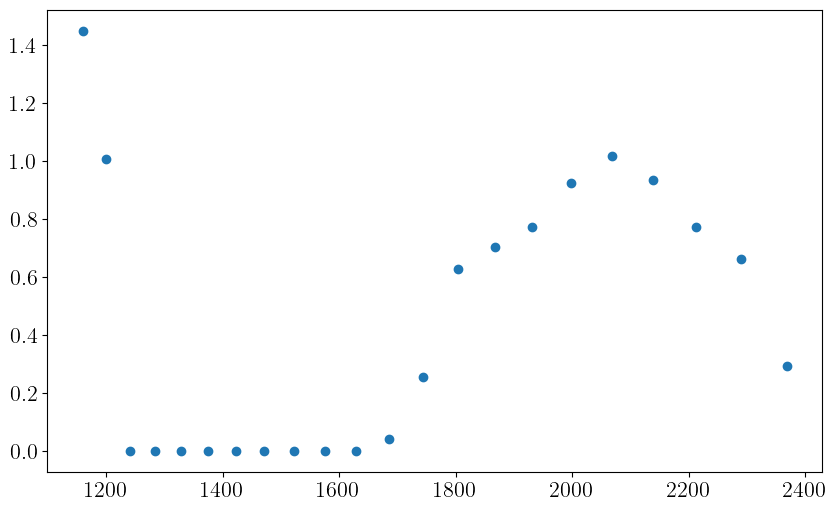

In [ ]:
# plot circular retardance
params, fig, ax = plot_config_dict_vs_wavelength('image_rotator', 'phi_r', json_dir)
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(wavelength_bins, np.rad2deg(params))

# EVERYTHING BELOW THIS POINT IS OLD CODE. 

I used MCMC to fit for my HWP physical parameters. If you are redoing the HWP fit, you can minimize the naive retardance fits to the physical model like in Step 4. In MCMC I did a version of step 5. I found MCMC to be more accurate for this. 

# Step 4: Refine Retardance Model

This step depends heavily on what components you are fitting to. I'm going to make the IMR and HWP retardances a function of wavelength using the Joost t Hart 2021 physical models. I'll use the parameters we just fitted as my dataset. 

In [9]:
def phys_model_chisq(p0, wavelengths, retardances_hwp, errors_hwp, retardances_imr,errors_imr):
    """
    Calculate the chi squared for the physical model of CHARIS.
    
    Parameters:
    -----------
    p0 : list
        List of parameters [w_sio2, w_mgf2, d].
    
    wavelengths : numpy array
        Array of wavelengths that are in the data.

    retardances_hwp : list or numpy array
        Retardances of the HWP at the specified wavelengths.

    errors_hwp : list or numpy array
        Errors associated with the HWP retardances.

    retardances_imr : list or numpy array
        Retardances of the IMR at the specified wavelengths.
    
    errors_imr : list or numpy array
        Errors associated with the IMR retardances.
    
    Returns:
    --------
    float
        The chi squared value.
    """
    # Get model retardances
    model_hwp = HWP_retardance(wavelengths, p0[0], p0[1])
    model_imr = IMR_retardance(wavelengths, p0[2])
    # Calculate residuals
    residuals_hwp = (retardances_hwp - model_hwp) / errors_hwp
    residuals_imr = (retardances_imr - model_imr) / errors_imr
    # Calculate log-likelihood
    chisq_hwp = np.sum(residuals_hwp**2)
    chisq_imr = np.sum(residuals_imr**2)
    return chisq_hwp + chisq_imr

In [10]:

# Minimizing the physical model

p0 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021
wavelengths = wavelength_bins # CHARIS wavelength bins

# Defining reasonable bounds (these values shouldn't have changed much)
  
wsio2_bounds = (0.9*p0[0], 1.1*p0[0])
wmgf2_bounds = (0.9*p0[1], 1.1*p0[1])
d_bounds = (0.9*p0[2], 1.1*p0[2])
bounds = [wsio2_bounds, wmgf2_bounds, d_bounds]

# Extract our retardances and errors from the data
errors = np.array(errors)
hwp_retardances = df['hwp_phi'].values
imr_retardance = df['imr_phi'].values
hwp_errors = errors[:,1] 
imr_errors = errors[:,0]  

# Use a while loop to iteratively minimize the chi squared function
# Counters for iterative fitting

iteration = 1
previous_chisq = 1000000
new_chisq = 0

while abs(previous_chisq-new_chisq)> 0.01*abs(previous_chisq):
        previous_chisq = new_chisq
        result = minimize(phys_model_chisq,p0, args=(wavelengths, hwp_retardances, hwp_errors, imr_retardance, imr_errors), bounds=bounds,method='L-BFGS-B')
        p0 = result.x
        new_chisq = result.fun
        iteration += 1
        print(result)

hess_inv = result.hess_inv


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 318.37950521692875
        x: [ 1.627e+00  1.271e+00  2.606e+02]
      nit: 11
      jac: [ 3.997e-02  5.373e-02 -1.569e-03]
     nfev: 112
     njev: 28
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 318.379505216928
        x: [ 1.627e+00  1.271e+00  2.606e+02]
      nit: 1
      jac: [ 4.006e-02  5.394e-02 -1.569e-03]
     nfev: 32
     njev: 8
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [18]:
# Redo the fit without the degenerate point 

wavelengths2 = np.delete(wavelength_bins, [0,1,2,3,4])
p0_2 = [1.623, 1.268, 262.56] # starting guesses from Joost t Hart 2021

# Defining reasonable bounds (these values shouldn't have changed much)

wsio2_bounds2 = (0.9*p0_2[0], 1.1*p0_2[0])
wmgf2_bounds2 = (0.9*p0_2[1], 1.1*p0_2[1])
d_bounds2 = (0.9*p0_2[2], 1.1*p0_2[2])
bounds2 = [wsio2_bounds2, wmgf2_bounds2, d_bounds2]

# Extract our retardances and errors from the data
errors2 = np.delete(np.array(errors), [0,1,2,3,4], axis=0)
hwp_retardances2 = df['hwp_phi'].values
imr_retardance2 = df['imr_phi'].values
hwp_errors2 = errors2[:,1] 
imr_errors2 = errors2[:,0]  

# Remove the corresponding retardances for the removed bin

hwp_retardances2 = np.delete(hwp_retardances2, [0,1,2,3,4])
imr_retardance2= np.delete(imr_retardance2,[0,1,2,3,4])

# Use a while loop to iteratively minimize the chi squared function

# Counters for iterative fitting

iteration2 = 1
previous_logl2 = 1000000
new_logl2 = 0

while abs(previous_logl2-new_logl2)> 0.01*abs(previous_logl2):
        previous_logl2 = new_logl2
        result2 = minimize(phys_model_chisq,p0_2, args=(wavelengths2, hwp_retardances2, hwp_errors2, imr_retardance2, imr_errors2), bounds=bounds2)
        p0_2 = result2.x
        new_logl2 = result2.fun
        iteration2 += 1
        print(result2)






  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 254.32086531858943
        x: [ 1.690e+00  1.316e+00  2.611e+02]
      nit: 11
      jac: [ 2.994e+00 -3.785e+00 -1.964e-02]
     nfev: 120
     njev: 30
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 254.32086515624638
        x: [ 1.690e+00  1.316e+00  2.611e+02]
      nit: 1
      jac: [ 6.062e-02  1.816e-01 -1.938e-02]
     nfev: 12
     njev: 3
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [14]:
# Compare chi sq of all models

p0_Hart = [1.623, 1.268, 262.56]

# Hart chi sq

print("Hart:",phys_model_chisq(p0_Hart,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model with all bins

print("Our model with all bins:",phys_model_chisq(result.x,wavelengths, hwp_retardances,hwp_errors,imr_retardance,imr_errors))

# Our model without bin 4

print("Our model without bin 4:",phys_model_chisq(result2.x,wavelengths2, hwp_retardances2,hwp_errors2,imr_retardance2,imr_errors2))



Hart: 8447.5197089818
Our model with all bins: 2437.6683213792157
Our model without bin 4: 2126.588692030502


In [13]:
print(1.268*1.2)

1.5216


# Step 5: Fit for Offsets Globally

In [2]:
# Get interleaved values for all wavelength bins
csvdir = Path('datacsvs/csvs_nopickoff')

interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csvdir)

from vampires_calibration.constants import wavelength_bins
wavelength_bin = 15 # placeholder
epsilon_cal = 1 # defining as perfect, reasoning in Joost t Hart 2021
offset_imr = -0.0018
offset_hwp = -0.0022 
offset_cal = -0.0315 
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
d = 259.7
wsio2 = 1.617
wmgf2 = 1.264

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "wollaston_prism_function",
        "properties" : {"beam": 'o'}, 
        "tag": "internal",
    },
    "image_rotator" : {
        "type" : "SCExAO_IMR_function",
        "properties" : {"wavelength":wavelength_bins[wavelength_bin], "d": d, "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "two_layer_HWP_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lprot": { # changed from delta_theta to match Joost t Hart
        "type": "rotator_function",
        "properties" : {'pa':offset_cal},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal},
        "tag": "internal",
    }}
}
    
# Starting guesses

p0_dict = {
    "image_rotator" : 
        {"d":d,"delta_theta": offset_imr},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": offset_hwp},
    "lprot" : 
        {"pa": offset_cal},
}

system_mm = generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM
print(system_mm.evaluate())
p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5,5) 
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.8*p0[0], 1.2*p0[0])
wmgf2_bounds = (0.8*p0[1], 1.2*p0[1])
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
# Process everything into double differences and propagate errors





[[0.99999962 0.99999962 0.         0.        ]
 [0.99999962 0.99999962 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


In [4]:
# Minimize everything globally with minimize
from vampires_calibration.fitting import minimize_system_mueller_matrix
result_min, logl_min=minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=bounds,mode='minimize')
print(result_min)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2.374995187507172
        x: [ 2.596e+02 -2.091e-01  1.648e+00  1.287e+00 -1.328e+00
            -6.904e-01]
      nit: 36
      jac: [ 1.810e-02 -2.144e-03 -1.855e-02  2.521e-02 -3.083e-04
            -2.074e-03]
     nfev: 308
     njev: 44
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [20]:
# Minimize everything globally with least squares
    # Counters for iterative fitting

iteration = 1
previous_logl = 1000000
new_logl = 0

    # Perform iterative fitting
    # MODIFY THE BOUNDS INPUT HERE IF YOU WANT TO CHANGE PARAMETERS
while abs(previous_logl - new_logl) > 0.01*abs(previous_logl):
    if iteration > 1:
        previous_logl = new_logl
    # Configuring minimization function for CHARIS
    result, new_logl, error = minimize_system_mueller_matrix(p0_dict, system_mm, interleaved_values_all, 
        interleaved_stds_all, configuration_list_all, process_dataset=process_dataset,process_model=process_model,process_errors=process_errors,include_sums=False, bounds = bounds,mode='least_squares')
    print(result)

    # Update p0 with new values

    update_p0(p0_dict, result.x)
    iteration += 1

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.6972e+08                                    2.63e+09    
       1              2         5.8343e+08      3.86e+08       1.12e+00       4.76e+08    
       2              3         5.5613e+08      2.73e+07       5.86e-01       8.01e+07    
       3              4         5.4358e+08      1.25e+07       2.05e+00       2.15e+07    
       4              5         5.2439e+08      1.92e+07       3.78e+00       5.84e+06    
       5              6         5.2196e+08      2.43e+06       5.34e-01       2.59e+06    
       6              7         5.2194e+08      2.48e+04       1.56e-02       4.76e+05    
       7              8         5.2194e+08      2.36e+03       3.30e-03       7.42e+04    
       8              9         5.2194e+08      1.64e+01       4.51e-04       6.81e+03    
       9             10         5.2194e+08      1.36e-01       4.01e-05       6.06e+02    

In [18]:
# Constrain offsets more
offset_bounds2 = (-1,1)
bounds=[d_bounds,offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
result2, logl2,error2 = minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,interleaved_stds_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=[d_bounds,offset_bounds2,wsio2_bounds,wmgf2_bounds,offset_bounds2,offset_bounds2],mode='least_squares')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0580e+09                                    6.31e+09    
       1              2         5.9708e+08      4.61e+08       5.05e+00       5.00e+08    
       2              3         5.0370e+08      9.34e+07       1.29e+00       5.14e+08    
       3              4         4.7468e+08      2.90e+07       3.67e-01       3.00e+08    
       4              5         4.6572e+08      8.96e+06       1.38e-01       1.58e+08    
       5              6         4.6318e+08      2.54e+06       4.61e-02       8.00e+07    
       6              7         4.6271e+08      4.66e+05       1.22e-02       4.67e+07    
       7              8         4.6260e+08      1.13e+05       1.26e-02       3.95e+07    
       8              9         4.6253e+08      6.61e+04       1.09e-02       3.37e+07    
       9             10         4.6249e+08      3.84e+04       8.82e-03       2.79e+07    

In [47]:
# now try with naive model

# get naive fit retardances (where offsets were fit to)

df = model_data('system_dictionaries/scipy_minimize_just_rets',offsets=False )
hwp_phi_list = df['hwp_phi'].values
imr_phi_list = df['imr_phi'].values
lp_eps_list = df['lp_epsilon'].values


# repeat each retardance for each measurement in csv
hwp_phi_list = np.array([i for i in hwp_phi_list for _ in range(64)])
imr_phi_list = np.array([i for i in imr_phi_list for _ in range(64)])
lp_eps_list = np.array([i for i in lp_eps_list for _ in range(64)])
bin_list = np.array([i for i in wavelength_bins for _ in range(64)])
df

,wavelength_bin,imr_phi,hwp_phi,lp_epsilon
0,1159.5614,4.312588,3.101307,0.998456
1,1199.6971,4.033282,3.185048,0.975938
2,1241.2219,3.800745,3.269217,0.984128
3,1284.1840,3.546170,3.267371,0.981444
4,1328.6331,3.411112,3.257679,0.989777
5,1374.6208,2.762574,2.735031,1.000000
6,1422.2002,2.490472,2.763097,1.000000
7,1471.4264,2.200012,2.841670,0.993980
8,1522.3565,1.946236,2.884687,0.987272
9,1575.0495,1.732104,2.904064,0.987299
